# Proper orthogonal decomposition (POD)
In this example, we will demonstrate the use of proper orthogonal decomposition (POD) for
decomposing a flow field into basis modes.

In [1]:
using ILMPostProcessing
using Plots

## Get the flow field data
First, we need some flow field data to analyze. For this purpose, we will use [ViscousFlow.jl](https://github.com/JuliaIBPM/ViscousFlow.jl)
to get snapshots of the flow for a flat plate at 30 degrees angle of attack at
Reynolds number 100.

In [2]:
using ViscousFlow

my_params = Dict()
my_params["Re"] = 100
my_params["freestream speed"] = 1.0 # in x-dir
my_params["freestream angle"] = 0.0 # relative to horizontal

xlim = (-1.0, 5.0)
ylim = (-2.0, 2.0)
my_params["grid Re"] = 4.0

g = setup_grid(xlim, ylim, my_params)

Δs = surface_point_spacing(g, my_params)
body = Plate(1.0, Δs)

cent = [0.5,0.0]
α = -30π/180
X = MotionTransform(cent, α)
joint = Joint(X)

m = RigidBodyMotion(joint, body)
x = init_motion_state(body, m)
update_body!(body, x, m)
sys = viscousflow_system(g, body, phys_params = my_params, motions = m);

u0 = init_sol(sys)
tspan = (0.0, 20.0)
integrator = init(u0, tspan, sys)

# Solve to 10 convective time units
step!(integrator, 10)

## Assemble snapshots of the velocity field from the solution data
Here, we make use of the capability of the `velocity` function to
generate an array of velocity fields at a range of times. We will
save every 5th time step in this array.

In [3]:
sol = integrator.sol
tpod = sol.t[2:5:end]
X = velocity(sol, sys, tpod);

## Perform the POD
The POD is simply performed with the `PODModes` function. This provides
a structure containing the modes (`phi`), the expansion coefficients (`a`), and the modal
energies (`lambda`). By default, `PODModes` retains 99% of the energy. This can be changed
with the optional argument `tolerance`.

In [4]:
modes = PODModes(X);

 The `a` array is of size $N_t \times r$, where $N_t$ is the number of time values,
and $r$ is the number of modes. The modes are ordered from highest energy to lowest energy.

In [5]:
modes.a

101×10 Matrix{Float64}:
  0.1362      0.00590038   -0.074342   …  -0.0249002    -0.0118274
  0.13486     0.00604169   -0.073411      -0.017327     -0.00745672
  0.132974    0.00631384   -0.0727776     -0.00905464   -0.00306749
  0.130734    0.00700557   -0.0725036     -0.00100462    0.000855249
  0.128309    0.00831983   -0.0724621      0.00594111    0.00399412
  0.125866    0.0103559    -0.0724235  …   0.0111991     0.00622499
  0.123562    0.0131053    -0.0721038      0.014568      0.00754335
  0.12153     0.0164598    -0.0712076      0.0161592     0.00796384
  0.119871    0.0202297    -0.069466       0.0162546     0.00747103
  0.118643    0.0241676    -0.0666655      0.0151638     0.00604517
  ⋮                                    ⋱                
 -0.106426   -0.0365209    -0.047604      -0.0114983     0.00848806
 -0.10824    -0.0254328    -0.0544178     -0.00854652    0.00992081
 -0.109189   -0.0133912    -0.0594459     -0.00455031    0.00995352
 -0.109244   -0.000630492  -0.06254

In this case, 7 modes were retained, at 51 times.

If we wanted to re-assemble the modes and coefficients to recover the flow at some time instant, we could
use the `mapreduce` function, e.g.,

In [6]:
vel_assemble = mapreduce((aj, phi_j) -> aj .* phi_j, +, modes.a[end,:], modes.phi) + modes.Xmean

CartesianGrids.Edges{CartesianGrids.Primal, 160, 110, Float64, Vector{Float64}} data
u (in grid orientation)
109×160 Matrix{Float64}:
 1.02936   1.03106   1.0327    1.03431   …  0.991007  0.989555  0.988499
 1.02863   1.0303    1.03196   1.03361      0.989991  0.988613  0.987428
 1.0278    1.02946   1.03112   1.03278      0.988884  0.987534  0.986294
 1.02689   1.02855   1.03021   1.03188      0.98768   0.98633   0.985058
 1.02591   1.02757   1.02923   1.03091      0.98637   0.985011  0.983718
 1.02486   1.02652   1.02818   1.02986   …  0.984951  0.983582  0.982273
 1.02374   1.0254    1.02706   1.02875      0.983422  0.982045  0.980726
 1.02255   1.0242    1.02587   1.02755      0.981782  0.980401  0.979077
 1.02128   1.02293   1.0246    1.02628      0.98003   0.978648  0.977324
 1.01993   1.02158   1.02324   1.02492      0.978165  0.976786  0.975467
 ⋮                                       ⋱                      
 0.955394  0.955539  0.955693  0.955859  …  1.03731   1.03551   1.03363

In this last line, `modes.a[end,:]` obtains the expansion coefficients at the last time
available.

Let's print the first mode, and the corresponding history of the modal coefficient in the decomposition

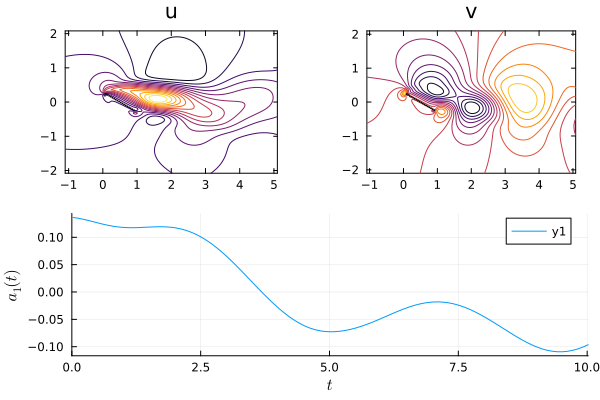

In [7]:
plot(layout=[2;1],plot(modes.phi[1].u,sys,title="u"),
   plot(modes.phi[1].v,sys,title="v"),
   plot(tpod,modes.a[:,1],xlim=(0,Inf),xlabel="\$t\$",ylabel="\$a_1(t)\$"))

The energy associated with this mode is

In [8]:
modes.lambda[1]

0.6848021811354754

Now let's print the $r$th mode, and the history of the coefficient in the decomposition

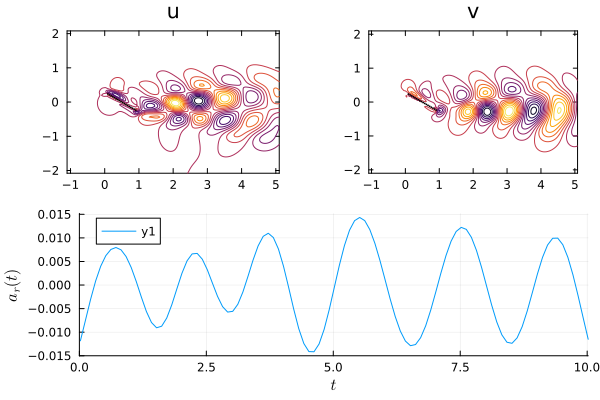

In [9]:
plot(layout=[2;1],plot(modes.phi[end].u,sys,title="u"),
   plot(modes.phi[end].v,sys,title="v"),
   plot(tpod,modes.a[:,end],xlim=(0,Inf),xlabel="\$t\$",ylabel="\$a_r(t)\$"))

The energy associated with this mode is

In [10]:
modes.lambda[end]

0.006473155258260422

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*